<a href="https://colab.research.google.com/github/Data-Science-Jagannath/Legality/blob/main/Legality1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import cv2
import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch.optim as optim
from sklearn. model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/Kaggle'

In [ ]:
# %cd /content/drive/MyDrive/Kaggle

/content/drive/MyDrive/Kaggle


In [ ]:
# !kaggle datasets download -d ishanikathuria/handwritten-signature-datasets

In [ ]:
# !unzip \*.zip && rm*.zip

Streaming output truncated to the last 5000 lines.
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-18.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-19.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-20.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-21.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-22.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-23.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-24.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-25.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-26.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-27.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-28.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-29.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-F-30.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-G-01.tif  
  inflating: BHSig260-Hindi/BHSig260-Hindi/6/H-S-6-G-02.tif  
  inflating: BHSig2

In [3]:
if torch.cuda.is_available():
  print("CUDA is available")

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

The image is grayscale.


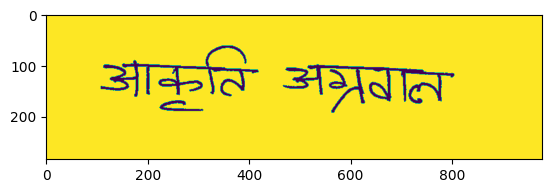

In [6]:
img = Image.open('/content/drive/MyDrive/Kaggle/BHSig260-Hindi/BHSig260-Hindi/1/H-S-1-F-01.tif')
plt.imshow(img)
if img.mode == "L":
    print("The image is grayscale.")
else:
    print("The image is not grayscale.")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# actual_dir = ["r'/content/drive/MyDrive/archive (7)/BHSig260-Bengali'","r'/content/drive/MyDrive/archive (7)/BHSig260-Hindi'","r'/content/drive/MyDrive/archive (7)/CEDAR'"]
# actual_dir = [r'/content/drive/MyDrive/archive (7)/BHSig260-Bengali',r'/content/drive/MyDrive/archive (7)/BHSig260-Hindi',r'/content/drive/MyDrive/archive (7)/CEDAR']

# actual_dir = r'/content/drive/MyDrive/archive (7)/BHSig260-Hindi'

# read path of image and labels
class ImageDataset(Dataset):
  def __init__(self, directory, transform=None):
    self.directory = directory
    self.transform = transform
    self.image_path = []
    self.labels = []

    for root, dirs, files in os.walk(directory):
      for file in files:
        if file.endswith((".png",".tif")):
          file_path = os.path.join(root, file)
          try:
            img = Image.open(file_path)
            self.image_path.append(file_path)
            self.labels.append(self.label_file(file))
          except Exception as e:
            print(f"error reading image: {file_path}")
            print(f"Error details: {e}")
            continue

  def label_file(self, file_name):
    if 'F' in file_name or 'forgeries' in file_name:
      return 1
    elif 'G' in file_name or 'original' in file_name:
      return 0
    else:
      raise ValueError(f"invalid label file name: {file_name}")

  def __len__(self):
    return len(self.image_path)

  def __getitem__(self, index):
    # if index = len(self.labels):
    #   raise IndexError("Index out of range")
    img_path = self.image_path[index]
    img = Image.open(img_path)
    # img = gray_img.convert("RGB")
    label = self.labels[index]

    if self.transform:
      img = self.transform(img)

    return img, label

In [22]:
image_size = 16
transform = transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])

In [ ]:
actual_dir_cedar = r'/content/drive/MyDrive/Kaggle/CEDAR/CEDAR'

dataset_cedar = ImageDataset(directory = actual_dir_cedar, transform=transform)

In [ ]:
actual_dir_hindi = r'/content/drive/MyDrive/Kaggle/BHSig260-Hindi/BHSig260-Hindi'

dataset_hindi = ImageDataset(directory = actual_dir_hindi, transform=transform)

In [ ]:
actual_dir_bengali = r'/content/drive/MyDrive/Kaggle/BHSig260-Bengali/BHSig260-Bengali'

dataset_bengali = ImageDataset(directory = actual_dir_bengali, transform=transform)

In [ ]:
combined_dataset = ConcatDataset([dataset_cedar, dataset_hindi, dataset_bengali])

In [19]:
class CNN(nn.Module):
  def __init__(self, out1 = 16, out2=32,number_of_classes=2):
    super(CNN,self).__init__()
    self.cnn1 = nn.Conv2d(in_channels=1,out_channels=out1, kernal_size=5, stride=1,padding=2)
    self.conv1_bn = nn.BatchNorm2d(out1)

    self.Maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(in_channels=out1,out_channels=out2, kernal_size=5, stride=1,padding=2)
    self.cnn2_bn = nn.BatchNorm2d(out2)

    self.maxpool2 = nn.MaxPool2d(kernel_size=2)
    self.fc1 = nn.Linear(out2*4*4, number_of_classes)
    self.bn_fc1 = nn.BatchNorm1d(number_of_classes)

    def forward(self,x):
      x = self.conv1(x)
      x = self.conv1_bn(x)
      x = torch.relu(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.cnn2_bn(x)
      x = torch.relu(x)
      x = self.maxpool2(x)
      x = x.view(x.size(0),-1)
      x = self.fc1(x)
      x = self.bn_fc1(x)
      return x

In [ ]:
len(dataset_cedar)

In [ ]:
len(dataset_hindi)

In [ ]:
len(dataset_bengali)

In [ ]:
len(combined_dataset)

In [ ]:
# list(range(len(combined_dataset)))

In [ ]:
train_index, validation_index = train_test_split(list(range(len(combined_dataset))),test_size=0.2,random_state=42)

train_data = torch.utils.data.Subset(combined_dataset, train_index)

validation_data = torch.utils.data.Subset(combined_dataset, validation_index)

In [ ]:
len(train_data)

13344

In [ ]:
len(train_index)

13344

In [ ]:
len(validation_data)

3336

In [ ]:
from torch import nn

In [ ]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr = 0.01)

In [ ]:
train_dataset = DataLoader(train_data, batch_size = 64, shuffle=True)
validation_dataset = DataLoader(validation_data, batch_size = 64, shuffle=True)

In [ ]:
epochs = 10
for epoch in range(epochs):
  model.train()
  LOSS = 0.0
  for images, labels in train_dataset:
    image, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    LOSS += loss.item()
  print(f"Epoch {epoch+1}, Loss: {LOSS/len(train_dataset)}")

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[64, 1, 128, 128] to have 3 channels, but got 1 channels instead